# P5: Photometric Stereo and Structure from Motion

## P5.1 Lighting a Scene

In class we talked about the properties of light. One of the topics we discussed was how we could compute the scene lighting of a Lambertian object from its normals and its albedo (and assuming we know where the light is). This process is relatively "simple" once you understand what's going on. For a Lambertian object, the amount of light collected by a light source is proportional to the cosine of the angle between the surface and the light source. So, for every point on the surface $\mathbf{x}$:

$$ \text{Observed Brightness}(\mathbf{x}) = \text{Albedo}(\mathbf{x})\cos(\theta_\mathbf{x}) = \text{Albedo}(\mathbf{x}) \left[ \hat{l} \cdot \hat{n}(\mathbf{x}) \right] $$

where $\hat{l}$ is the *light direction* (normalized) and $\hat{n}(\mathbf{x})$ is the *surface normal* at location $\mathbf{x}$.

For this breakout session, I have provided you with an *albedo matrix* `albedos` (of dimension $m \times n$) and the accompanying *normals* `normals` (of dimension $m \times n \times 3$, where the normal vector at coordinate `i, j` is `normals[i, j]`).

**TASK** Write a function `light_scene` that computes an $m \times n$ "lit scene" image from (1) the albedos, (2) the normals, and (3) the light directions.

I have provided you with both data and some partially-implemented functions for this process. If your `light_scene` function is implemented correctly, the `light_scene_interactive` function I have included below should instantiate an interactive widget with which you can move the light around with sliders and see the effect.

**PLOTS** Include 4 different lightings of the "bunny" scene in your writeup.

*Data and Images* from: 
- Buddah: https://courses.cs.washington.edu/courses/csep576/05wi/projects/project3/project3.htm
- Scholar: http://vision.seas.harvard.edu/qsfs/Data.html

In [1]:
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load Data
stanford_bunny_dat = np.load('stanford_bunny_dat.npz')
normals = stanford_bunny_dat['arr_0'][:, :, :3]
albedos = stanford_bunny_dat['arr_0'][:, :, 3]

# Function you will be implementing
def light_scene(albedos, normals, light_direction):
    observed_brightness = albedos * (np.dot(normals, light_direction))
    return observed_brightness

interactive(children=(FloatSlider(value=0.0, description='th_x', max=0.8, min=-0.8, step=0.05), FloatSlider(va…

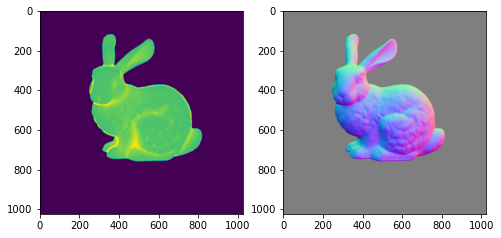

In [2]:
# Visualization Functions
def visualize_normals(normals, ax=None):
    if ax is None:
        plt.figure(dpi=300)
    plt.imshow(0.5 * normals + 0.5)
    
def light_scene_interactive(albedos, normals):
    def inter(th_x, th_y):
        sth_x = np.sin(th_x)
        sth_y = np.sin(th_y)
        light_direction = [
            sth_x, sth_y, np.sqrt(1 - sth_x**2 - sth_y**2)
        ]
        ld = light_direction
        print(f"Light Direction: x={ld[0]:0.3f}, y={ld[1]:0.3f}, z={ld[2]:0.3f}")

        plt.figure(2)
        imobj = plt.imshow(light_scene(albedos, normals, light_direction),
               vmin=0.0, vmax=0.7, cmap='gray')
        plt.show()

    return interactive(inter, th_x=(-0.8, 0.8, 0.05), th_y=(-0.8, 0.8, 0.05))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(albedos)
ax = plt.subplot(1, 2, 2)
visualize_normals(normals, ax=ax)

light_scene_interactive(albedos, normals)

## P5.2 Photometric Stereo

Now that you see how to light a scene, we will now investigate how to invert this process: a technique known as *photometric stereo*.

### P5.2.1 Using provided data

I have provided you with some data in the folders `buddah` and `scholar` which contain grayscale `.tga` images and a file `light_directions.txt`. Each line of `light_directions.txt` is a 3-element vector indicating the direction of the light source from the object corresponding to that image. **IMPORTANT:** the light directions for the buddah data are in numerical order of the images. `light_directions[0]` corresponds to `buddah.0.tga` and so on. Sorting by order on some file systems will place `buddah.10.tga` before `buddah.2.tga`: **this is incorrect and will result in incorrect results**.

**TASK** Implement photometric stereo as discussed in `L09.2`.

**NOTE**: This function may return incorrect values where the albedo is zero. Feel free to add small values to the albedo, or add "fake" `[0, 0, 0]` values for the normals where they would otherwise be not well defined.

**PLOTS** Plot (1) the computed normals, (2) the computed albedo, and (3) the reconstructed depth image (via the `integrateFrankot` function provided below) for each of the `buddah` and `scholar` datasets.

I have included the `integrateFrankot` function below and an example using the "bunny" data from above to reconstruct the depth image corresponding to your computed surface normals.  

In [3]:
import numpy as np
from PIL import Image
import warnings


def load_image_gray(filepath):
    img = Image.open(filepath)
    img = np.asarray(img).astype(np.float)/255
    if len(img.shape) > 2:
        return img[:, :, 0]
    else:
        return img

In [4]:
import numpy as np
from scipy import misc
from matplotlib import pyplot as plt


def sanitise_image(image):
    return (image / 255).flatten()


def photometric_stereo(images, L):

    original_size = images[0].shape[:2]

    images = np.vstack(map(sanitise_image, images))

    L = L / np.linalg.norm(L, ord=2, axis=1, keepdims=True)

    norm_sln = np.linalg.pinv(L.T.dot(L)).dot(L.T)

    G = np.einsum("ij,il", norm_sln, images)

    comp_albedo = np.linalg.norm(G, axis=0)

    comp_normals = np.divide(G, np.vstack([comp_albedo] * 3))

    comp_albedo = comp_albedo.reshape(original_size)

    comp_normals = comp_normals.T.reshape(original_size[0], original_size[1], 3)

    return comp_normals, comp_albedo


In [5]:
import numpy as np
from skimage.io import imread
from skimage.color import rgb2xyz
from matplotlib import pyplot as plt
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings

def integrateFrankot(normals):

    zx = -normals[:, :, 0]
    zy = normals[:, :, 1]
    pad = max(normals.shape)

    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    h, w = pad, pad

    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


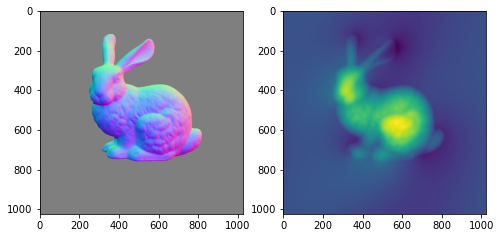

In [6]:
stanford_bunny_dat = np.load('stanford_bunny_dat.npz')
normals = stanford_bunny_dat['arr_0'][:, :, :3]
normals = np.nan_to_num(normals)
depth = integrateFrankot(normals)
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
visualize_normals(normals, ax=ax)
plt.subplot(1, 2, 2)
plt.imshow(depth)
None

<ipython-input-4-04cc79270a51>:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  images = np.vstack(map(sanitise_image, images))


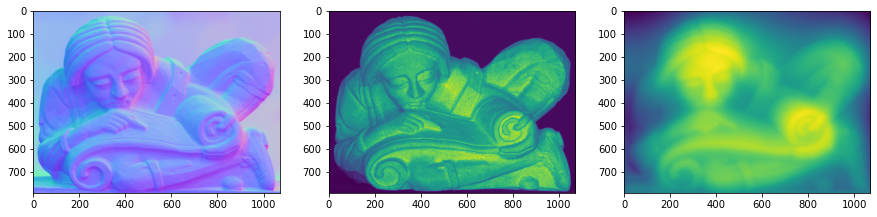

In [7]:
L = np.loadtxt('./scholar/light_positions.txt').T

images = []
for i in range(L.shape[1]):
    im_file = './scholar/Image_'+str(i)+'.png'
    images.append(load_image_gray(im_file))
    
comp_normals_scholar, comp_albedo_scholar = photometric_stereo(images, L)
comp_normals_scholar = np.nan_to_num(comp_normals_scholar)
depth_scholar = integrateFrankot(comp_normals_scholar)
plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 3, 1)
visualize_normals(comp_normals_scholar, ax=ax)
plt.subplot(1, 3, 2)
plt.imshow(comp_albedo_scholar)
plt.subplot(1, 3, 3)
plt.imshow(depth_scholar)


<ipython-input-4-04cc79270a51>:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  images = np.vstack(map(sanitise_image, images))


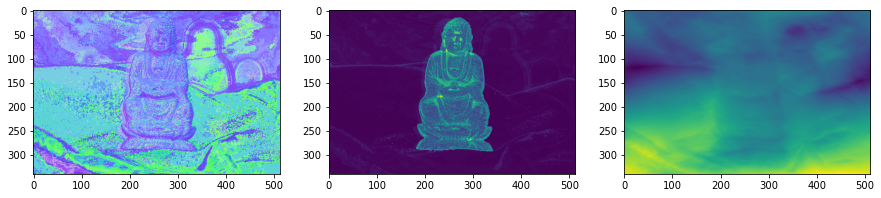

In [8]:
L = np.loadtxt('./buddah/light_positions.txt').T

images = []
for i in range(L.shape[1]):
    im_file = './buddah/buddha.'+str(i)+'.png'
    images.append(load_image_gray(im_file))
    
comp_normals_buddha, comp_albedo_buddha = photometric_stereo(images, L)
comp_normals_buddha = np.nan_to_num(comp_normals_buddha)
depth_buddha = integrateFrankot(comp_normals_buddha)
plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 3, 1)
visualize_normals(comp_normals_buddha, ax=ax)
plt.subplot(1, 3, 2)
plt.imshow(comp_albedo_buddha)
plt.subplot(1, 3, 3)
plt.imshow(depth_buddha)


### P5.2.2 Imperfections in Photometric Stereo

Using photometric stereo, you have just computed the surface normals and albedo of a few objects. However, for photometric stereo to work, we make some significant assumptions about the structure of the scene and the material properties of the object. In this question, we will use the computed normals and albedos to relight the scene and you will comment on the differences between the "reconstructed" image as compared to the original.

**TASK** Using your answer to P5.1, relight the scholar object to approximately recreate `scholar/image_11.png` (using `light_positions[10]` from the `scholar` data).

**PLOTS*** Plot (1) the original `scholar/image_11.png`, (2) your reconstructed "relit" image corresponding to that scene, and (3) the difference between the two images (use `cmap='PiYG', vmin=-0.3, vmax=0.3` as arguments to `imshow`).

In ideal photometric stereo, these images should be identical. However, you should notice some differences between your image and the reconstruction, particularly to the lower-left of the face.

**QUESTION** Explain (in 2–3 sentences) why there is a significant difference between the two images to the lower-left of the scholar's face.

**QUESTION** Provide an explanation (in 2–3 sentences) why the body of the scholar is (on average) darker in the original image than in the reconstruction. (There are a few potential explanations to this question.)

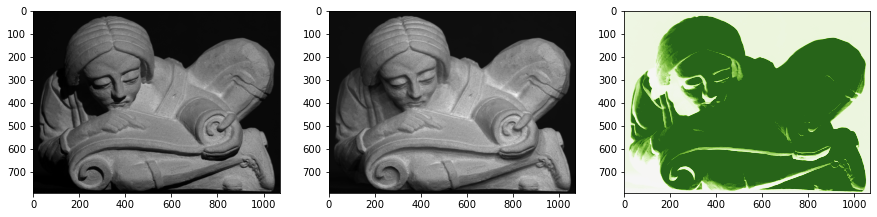

In [9]:
L = np.loadtxt('./scholar/light_positions.txt')


im_file = './scholar/Image_10.png'
image = load_image_gray(im_file)


relit_img = light_scene(comp_albedo_scholar, comp_normals_scholar, L[10])

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap = 'gray')
plt.subplot(1, 3, 2)
plt.imshow(relit_img, cmap = 'gray')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(image - relit_img), cmap='PiYG', vmin=-0.3, vmax=0.3)


### P5.2.3 Lambertian Objects in Blender

I have provided you with a scene in Blender `photometric_stereo.blend` that you will use to generate data of your own. The scene is already arranged so that you can generate data: move around "Light Source", render the image, and record the "light direction" in `light_positions.txt`. The scene is structured such that simply including the x, y, z coordinates of the light in that file will match the format of the other datasets you have been provided. **Important**: for photometric stereo, the light positions need to be normalized! If you are not normalizing your light directions before computing the albedo and normals, you will need to do so. Also, it is recommended that you move the light only in X and Y, so that you have one fewer variable to worry about.

**TASK & PLOTS** Generate at least 4 images using Blender for different light positions and include plots of those images.

**PLOTS** Use photometric stereo to compute and plot the (1) albedos, (2) normals, and (3) depth for the blender scene.

<ipython-input-4-04cc79270a51>:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  images = np.vstack(map(sanitise_image, images))
<ipython-input-4-04cc79270a51>:24: RuntimeWarning: invalid value encountered in true_divide
  comp_normals = np.divide(G, np.vstack([comp_albedo] * 3))


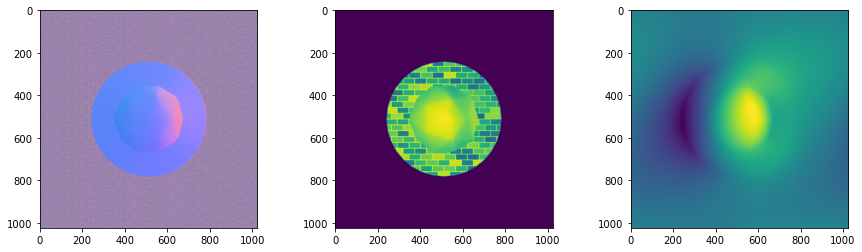

In [10]:
L = np.loadtxt('./lambert/light_positions.txt').T

images = []
for i in range(L.shape[1]):
    im_file = './lambert/lam'+str(i)+'.png'
    images.append(load_image_gray(im_file))
    
comp_normals_lam, comp_albedo_lam = photometric_stereo(images, L)
comp_normals_lam = np.nan_to_num(comp_normals_lam)
depth_lam = integrateFrankot(comp_normals_lam)
plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 3, 1)
visualize_normals(comp_normals_lam, ax=ax)
plt.subplot(1, 3, 2)
plt.imshow(comp_albedo_lam)
plt.subplot(1, 3, 3)
plt.imshow(depth_lam)


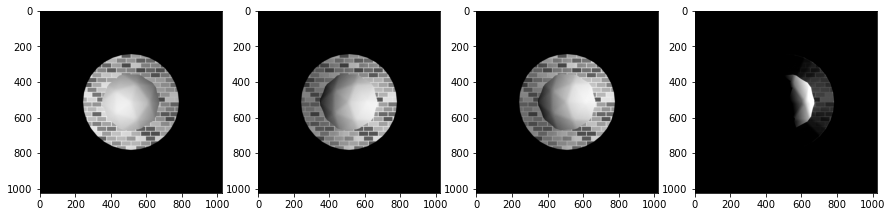

In [11]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.imshow(images[0], cmap = 'gray')
plt.subplot(1, 4, 2)
plt.imshow(images[1], cmap = 'gray')
plt.subplot(1, 4, 3)
plt.imshow(images[2], cmap = 'gray')
plt.subplot(1, 4, 4)
plt.imshow(images[3], cmap = 'gray')

### P5.2.4 Non-Lambertian Objects in Blender

Modify the material of the central object in blender (the "Icosphere") so that it has `Metalic` value of `0.5`. The center object should now be shiny.

**TASK & PLOTS** Generate at least 4 images using Blender for different light positions and include plots of those images with the new material property.

**PLOTS** Use photometric stereo to compute and plot the new (1) albedos, (2) normals, and (3) depth for your modified blender scene.

**QUESTION** Explain (2-3 sentences) why the albedo and normals change. Is there a linear solution to finding the correct normals?

**QUESTION** Find a research paper (I recommend using Google Scholar) that attempts "non-lambertian Photometric Stereo": trying to recover material properties for a non-lamberitan object, like the one shown above. Include a citation of the paper and (in 3–5 sentences) explain how it works and how the approach differs from the lambertian photometric stereo we studied in class.

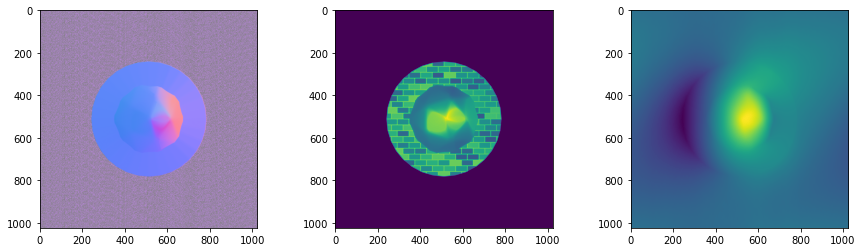

In [356]:
L = np.loadtxt('./nonlambert/light_positions.txt').T

images = []
for i in range(L.shape[1]):
    im_file = './nonlambert/nlam'+str(i)+'.png'
    images.append(load_image_gray(im_file))
    
comp_normals_nlam, comp_albedo_nlam = photometric_stereo(images, L)
comp_normals_nlam = np.nan_to_num(comp_normals_nlam)
depth_nlam = integrateFrankot(comp_normals_nlam)
plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 3, 1)
visualize_normals(comp_normals_nlam, ax=ax)
plt.subplot(1, 3, 2)
plt.imshow(comp_albedo_nlam)
plt.subplot(1, 3, 3)
plt.imshow(depth_nlam)


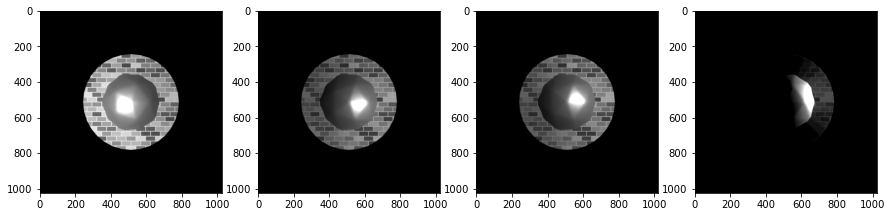

In [357]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.imshow(images[0], cmap = 'gray')
plt.subplot(1, 4, 2)
plt.imshow(images[1], cmap = 'gray')
plt.subplot(1, 4, 3)
plt.imshow(images[2], cmap = 'gray')
plt.subplot(1, 4, 4)
plt.imshow(images[3], cmap = 'gray')

## P5.3 Structure from Motion

The culminating assignment for the second unit of the course is scene reconstruction, also known as *Structure from Motion* (SfM). You will be asked to implement the simplified version of SfM we discussed in class: Affine Structure from Motion, in which the camera is assumed to have an orthographic projection of the scene.

### P5.3.1 Implementation

The general procedure for Affine SfM was fully derived in class. The general procedure is as follows:

<img src="images/affine_sfm_procedure.png" width="400">

I have provided you with code that completes the first couple of steps: I have detected features for each of the four provided images and computed feature matches using OpenCV. The feature matches, stored in `combined_matches`, are indexed according to (0) feature number, [1] image number, [2] coordinate. So the x-coordinate of detected feature 5 in image 3, would be `combined_matches[5, 3, 0]`.

Second, I have centered the points for each of the images. The resulting centered feature points are stored in the 3-dimensional data structure `matches_norm`. You should use this for constructing the measurement matrix `D`.

**TASK** Implement the procedure for Affine Structure from Motion so that you can compute the measurement matrix `M` and the shape matrix `S` as defined in the procedure above.

The final step of the algorithm above says to *Eliminate affine ambiguity*; I have provided you with code that does this in `correct_affine_ambiguity`, which takes in the `M` and `S` matrices you are to compute and returns the matrices `A` (containing the affine projection matrices) and `X`.

**TASK** Using your newly-computed affine projected matrices (stored in the matrix `A`), you can reproject the 3D points `X` into the image plane. Using the slides from class as a reference, define the function `reproject_image_points(A, X)`, which returns a single matrix `reprojected_image_points` (and has dimensions matching `combined_matches`, with coordinates [0] feature number, [1] image number, [2] coordinate. *Don't forget to re-add the `centers` vector after reprojecting.*

**PLOTS** If your functions are all defined correctly, run the code below under `Plotting: Affine SfM`. It should generate a set of 4 plots with the reprojected points overlaid on top of them; include the set of 4 images in your writeup. The four plots should look similar to this:

<img src="images/affine_sfm_reprojection.png" width="200">


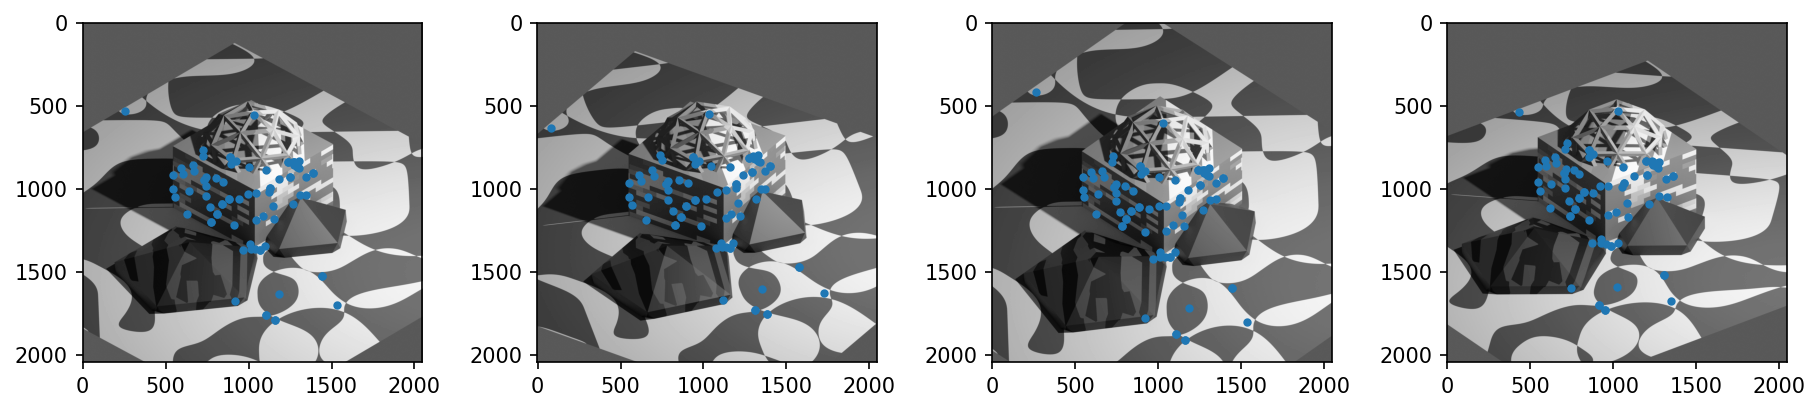

In [88]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from PIL import Image


img1 = cv.imread('SfM/simple_view_c.png',0) 
img2 = cv.imread('SfM/simple_view_1.png',0) 
img3 = cv.imread('SfM/simple_view_2.png',0) 
img4 = cv.imread('SfM/simple_view_3.png',0) 
sift = cv.SIFT_create()


def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

img1_color = load_image('SfM/simple_view_c.png')

def get_point_matches(img1, img2):

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
    search_params = dict(checks=100)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    good = []
    pts1 = []
    pts2 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
        
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    
    return np.stack((pts1, pts2), axis=1)


def combine_matches(matches_a, matches_b):

    combined_matches = []
    for ii in range(matches_a.shape[0]):
        ma0 = matches_a[ii, 0]

        mi = np.where((matches_b[:, 0] == ma0).all(axis=1))[0]

        if mi.size > 0:
            ma = matches_a[ii]
            mb = matches_b[int(mi[0])]
            combined_matches.append(np.concatenate(
                (ma, mb[1:]), axis=0))

    return np.array(combined_matches)


def get_match_colors(image_c, combined_matches):
    colors = []
    nm = combined_matches.shape[0]
    for mi in range(nm):
        m = combined_matches[mi, 0, :]
        colors.append(image_c[m[1]-1:m[1]+2,
                              m[0]-1:m[0]+2].sum(axis=0).sum(axis=0)/9)
    
    return colors


def correct_affine_ambiguity(M, S):
    Atilde = M
    Xtilde = S
    m = Atilde.shape[0]//2
    Am = np.zeros((3*m, 9))
    bm = np.zeros(3*m)
    for mi in range(m):
        Atl = Atilde[2*mi:2*mi+2]
        for ri in range(3):
            for ci in range(3):
                Am[3*mi+0, 3*ri + ci] = Atl[0, ri] * Atl[0, ci]
                bm[3*mi+0] = 1
                Am[3*mi+1, 3*ri + ci] = Atl[1, ri] * Atl[1, ci]
                bm[3*mi+1] = 1
                Am[3*mi+2, 3*ri + ci] = Atl[0, ri] * Atl[1, ci]
                bm[3*mi+2] = 0

    CCT = np.reshape(np.linalg.lstsq(Am, bm, rcond=None)[0], (3, 3))
        
    C = 0.5*(CCT + CCT.T)
    w, v = np.linalg.eig(C)
    CCT = v @ np.diag(np.abs(w)) @ np.linalg.inv(v)

    C = np.linalg.cholesky(CCT)
    
    A = Atilde @ C
    X = np.linalg.inv(C) @ Xtilde
    return A, X


matches_12 = get_point_matches(img1, img2)
matches_13 = get_point_matches(img1, img3)
matches_14 = get_point_matches(img1, img4)

combined_matches = combine_matches(matches_12, matches_13)
combined_matches = combine_matches(combined_matches, matches_14)
colors = get_match_colors(img1_color, combined_matches)

plt.figure(figsize=(15, 3), dpi=150)
stacked_images = (img1, img2, img3, img4)
num_images = len(stacked_images)
for ii in range(num_images):
    plt.subplot(1, num_images, ii+1)
    plt.imshow(stacked_images[ii], cmap='gray')
    plt.plot(combined_matches[:, ii, 0],
             combined_matches[:, ii, 1],
             '.')

centers = np.mean(combined_matches, axis=0)
matches_norm = combined_matches - centers

D = (8, matches_norm.shape[0])
D = np.zeros(D)
D[0] = matches_norm[:,0,0]
D[1] = matches_norm[:,0,1]
D[2] = matches_norm[:,1,0]
D[3] = matches_norm[:,1,1]
D[4] = matches_norm[:,2,0]
D[5] = matches_norm[:,2,1]
D[6] = matches_norm[:,3,0]
D[7] = matches_norm[:,3,1]
U,W,V = np.linalg.svd(D)
M = U[:, :3]
S = W[:3, :3] @ V[:, :3].T


def reproject_image_points(A, X, centers):  
    return combined_matches
    

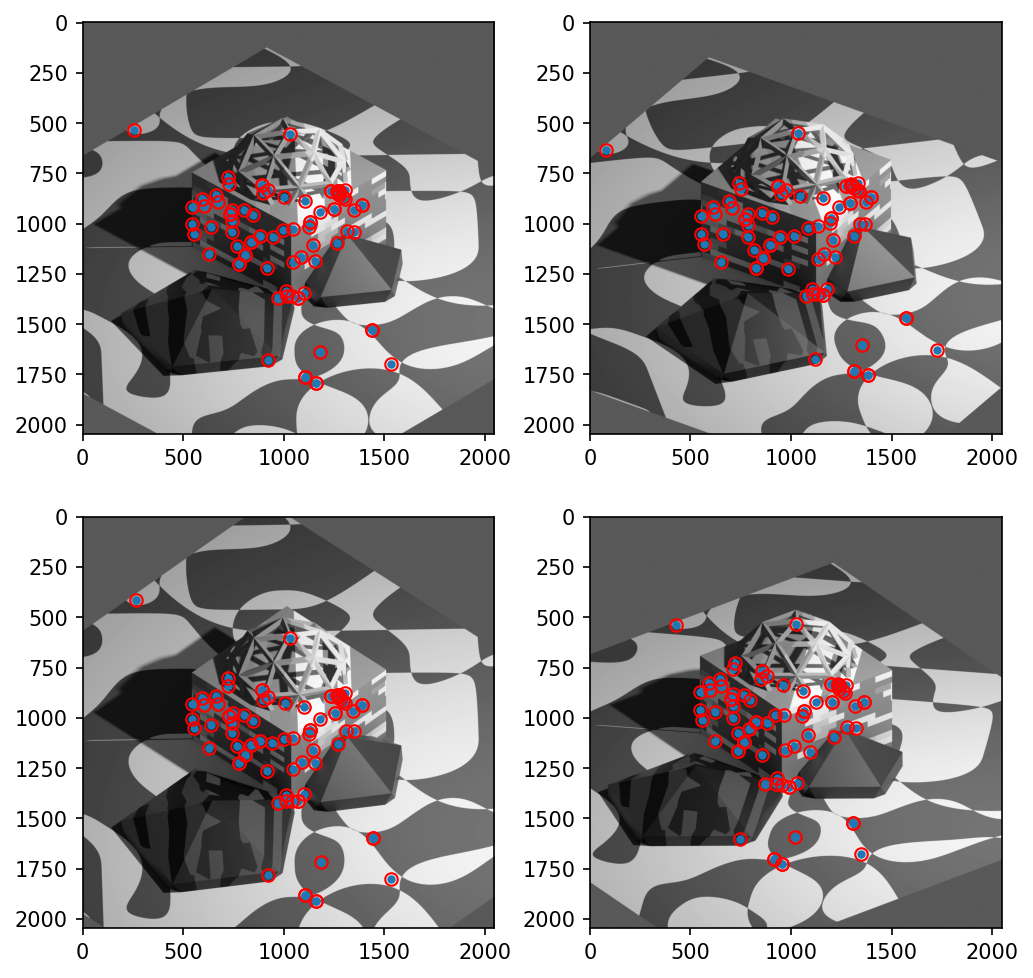

In [90]:
A, X = correct_affine_ambiguity(M, S)

reprojected_image_points = reproject_image_points(A, X, centers)

np.save("points.npy", X)
np.save("colors.npy", colors)

plt.figure(figsize=(8, 8), dpi=150)
stacked_images = (img1, img2, img3, img4)
num_images = len(stacked_images)
for ii in range(num_images):
    plt.subplot(2, 2, ii+1)
    plt.imshow(stacked_images[ii], cmap='gray')
    plt.plot(combined_matches[:, ii, 0],
             combined_matches[:, ii, 1],
             '.')
    plt.plot(reprojected_image_points[:, ii, 0],
             reprojected_image_points[:, ii, 1],
             'ro', markerfacecolor='none')

### P5.3.2 Followup Questions

I have provided you with some plotting code below in `Plotting Code 3D`, which you can use to view your computed 3D points in 3D. **I recommend you run this code in a terminal window, so that you can view it interactively.** The code above saves the data to file in `points.npy` and `colors.npy`, which the plotting code below reads in before visualization. Note also that I have given the features colors according to their color in the original image.

**PLOTS** Record 4 different perspectives on your scene using the 3D plotting code. One of those views should show that the points on the surface of the central cube are *coplanar* (i.e. generate a view from above or below the central cube so that you can tell that those points are roughly all on the same plane, as we expect).

**QUESTION** What is the relationship between the Affine matrix you have computed and the 3x4 camera projection matrix? Pick one of the input images above. Using the affine transformation matrix you computed for that image, what is the 3x4 camera projection matrix for this image? Include it in your writeup.

**QUESTION** I have provided you with the function `correct_affine_ambiguity` so that the Affine projective matrices produced by our algorithm satisfy certain properties. What are these properties? You may refer to the code itself or the course notes in your answer. It may help you to print the matrices before and after the correction is applied.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

X = np.load("points.npy")
colors = np.load("colors.npy")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0, :], X[1, :], X[2, :], c=colors)
ax.set_xlim3d([-750, 750])
ax.set_ylim3d([-750, 750])
ax.set_zlim3d([-750, 750])
plt.show()